### building blocks -> move to micrograd/ later

- skip to training code section if you want to run the model 
- below is to try to write code from scratch while watching the video

In [1]:
# choose env=research

import math
import numpy as np

import torch

import seaborn as sns
import matplotlib.pyplot as plt


np.random.seed(37)
torch.manual_seed(37)
%matplotlib inline

In [6]:
# data structure to hold mathematical expression of neural networks
class Value:
    def __init__(self, data):
        self.data = data
        self.grad = 0.0
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
a = Value(2.0)
a

Value(data=2.0, grad=0.0)

In [7]:
class Value:
    def __init__(self, data):
        self.data = data
        self.grad = 0.0
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data)
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data)
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self, other): # other * self
        return self.__mul__(other)
    
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)

# a += b
# a

# a.__add__(2)
# a += 2 
# a

# c = 1.0 + a
# c

# a.__mul__(b)
# a *= b
# a

d = a*b + c
d

Value(data=4.0, grad=0.0)

In [31]:
# add operation and components that led to a value (use children)
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)  # previous values that contributed to this value
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            data=self.data + other.data,
            _children=(self, other),
            _op="+",
            label=f"{self.label}+{other.label}"
        )
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            data=self.data * other.data, 
            _children=(self, other),
            _op="*",
            label=f"{self.label}+{other.label}"
        )
        return out
    
    def __pow__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(data=self.data ** other.data, _children=(self, other))
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self, other): # other * self
        return self.__mul__(other)
    
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
d = a*b + c
d._prev
# d._op

{Value(data=-6.0, grad=0.0), Value(data=10.0, grad=0.0)}

#### visualize comp graph

In [32]:
from graphviz import Digraph

def trace(root):
    """build a set of all nodes adn edges i na graph"""
    nodes, edges = set(), set()
    
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"}) # LR = left to right
    
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label=f"{n.label} | data: {n.data:.4f} | grad: {n.grad:.4f}", shape="record")
        if n._op:
            # if this node is a result of an operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

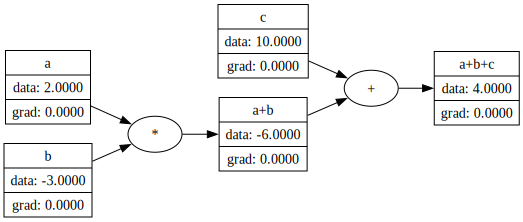

In [33]:
draw_dot(d)

In [55]:
a = Value(2.0, label="a")
b = Value(-3.0, label="b")
c = Value(10.0, label="c")
f = Value(-2.0, label="f")

e = a * b; e.label = "e" # -6.0
d = e + c; d.label = "d" # 4.0
L = d * f; L.label = "L" # -8.0
L

Value(data=-8.0, grad=0.0)

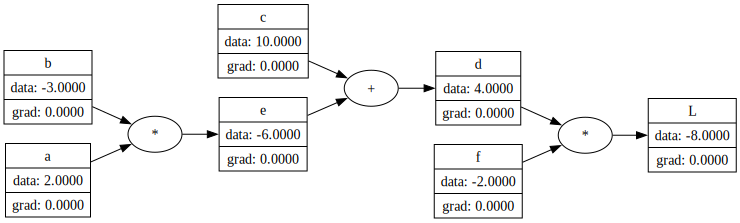

In [56]:
draw_dot(L)

#### manually calc gradients

In [57]:
# helper fn to see the effect on loss by nudging each node with tiny value ie., h 
def lol():
    h = 0.001
    
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    f = Value(-2.0, label="f")
    e = a * b; e.label = "e" # -6.0
    d = e + c; d.label = "d" # 4.0
    L = d * f; L.label = "L" # -8.0
    L1 = L.data
    
    a = Value(2.0, label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    f = Value(-2.0, label="f")
    e = a * b; e.label = "e" # -6.0
    d = e + c; d.label = "d" # 4.0
    L = d * f; L.label = "L" # -8.0
    L2 = L.data + h
    
    print((L2-L1)/h)
    
lol()

1.000000000000334


In [58]:
# L = d * f = (e + c) * f = ((a * b) + c) * f
L.grad = 1.0

d.grad = -2.0    # dL/dd = f
f.grad = 4.0    # dL/df = d

c.grad = -2.0    # dL/dc = dL/dd * dd/dc = -2.0 * 1.0
e.grad = -2.0    # dL/de = dL/dd * dd/de = -2.0 * 1.0

b.grad = 4.0     # dL/db = dL/de * de/db = -2.0 * a = -2. * 2.
a.grad = 6.0    # dL/da = dL/de * de/da = -2. * b = -2. * -3

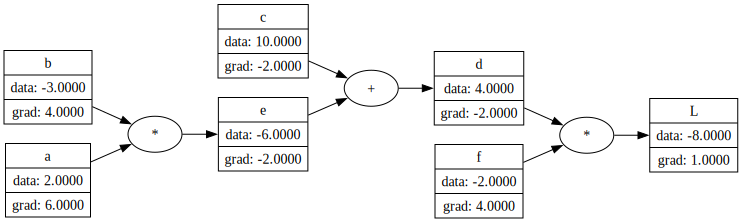

In [59]:
draw_dot(L)

In [60]:
# below represents 1 step in optimiziation
# nudge each leaf node in the direction of its gradient
# we expect to see lower L
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f
print(L.data)

-7.609504000000001


#### backpropagate through neuron

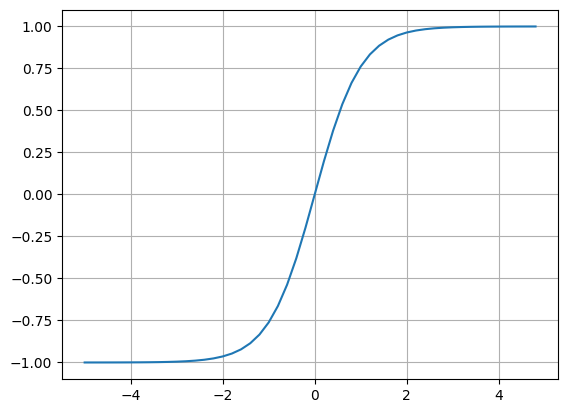

In [62]:
x = np.arange(-5, 5, 0.2)
plt.plot(x, np.tanh(x)); plt.grid();

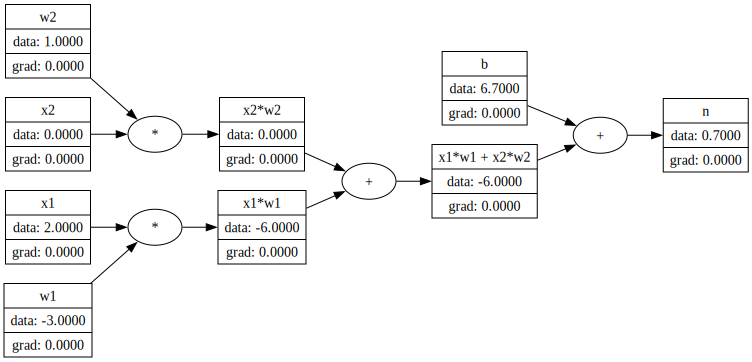

In [64]:
# 2 dimensional neuron looks like below

# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w1
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of neuron
b = Value(6.7, label="b")

# x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"

draw_dot(n)

In [ ]:
# add activation function: tanh
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)  # previous values that contributed to this value
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            data=self.data + other.data,
            _children=(self, other),
            _op="+",
            label=f"{self.label}+{other.label}"
        )
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            data=self.data * other.data, 
            _children=(self, other),
            _op="*",
            label=f"{self.label}+{other.label}"
        )
        return out
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
        out = Value(t, _children=(self,), _op="tanh", label=f"tanh({self.label})")
        return out
        
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self, other): # other * self
        return self.__mul__(other)

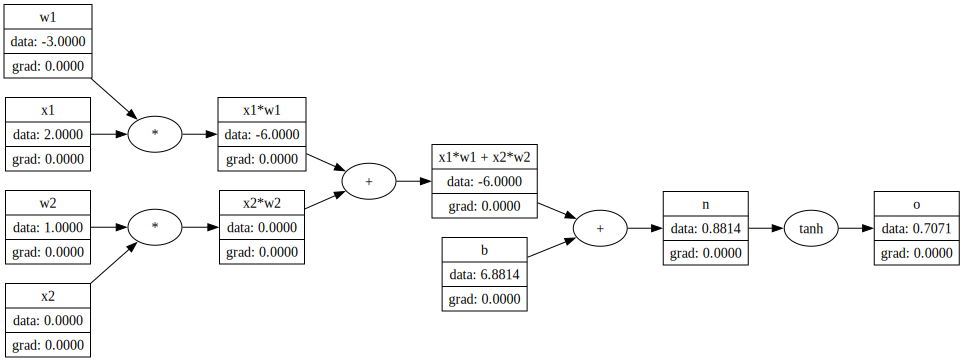

In [67]:
# 2 dimensional neuron looks like below

# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w1
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of neuron
b = Value(6.8813735870195432, label="b")

# n = x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"

# o = tanh(n)
o = n.tanh(); o.label = "o"
draw_dot(o)

In [75]:
o.grad = 1.0

n.grad = 0.5 # do/dn = d(tanh(n))/dn = 1 - tanh^2(n) = 1 - o^2

x1w1x2w2.grad = 0.5 # do/dx1w1x2w2 -> notice "+" node's observation
b.grad = 0.5 # do/db

x1w1.grad = 0.5 # do/dx1w1 -> notice "+" node's observation
x2w2.grad = 0.5 # do/dx2w2

x1.grad = -0.15 # do/dx1 = 0.5 * w1
w1.grad = 1.0 # do/dw1 = 0.5 * x1

x2.grad = 0.5 # do/dx2 = 0.5 * w2
w2.grad = 0.0 # do/dw2 = 0.5 * x2

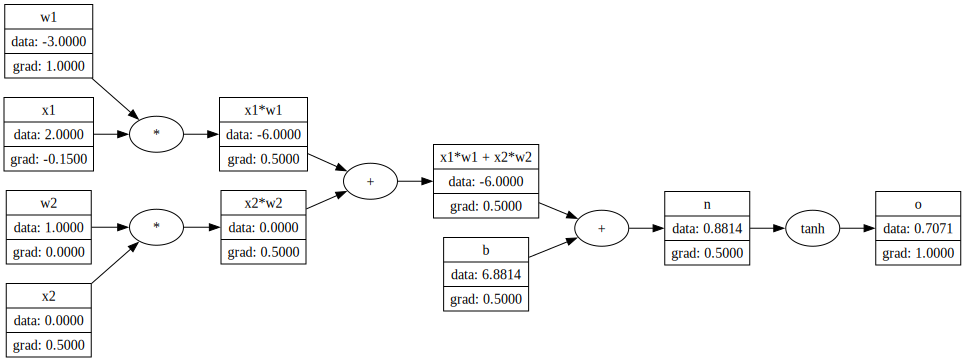

In [76]:
draw_dot(o)

#### add backward pass

In [77]:
# chain rule: local gradient = local derivative * outer gradient
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)  # previous values that contributed to this value
        self._op = _op
        self.label = label
        self._backward = lambda: None
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            data=self.data + other.data,
            _children=(self, other),
            _op="+",
            label=f"{self.label}+{other.label}"
        )
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            data=self.data * other.data, 
            _children=(self, other),
            _op="*",
            label=f"{self.label}+{other.label}"
        )
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
        out = Value(t, _children=(self,), _op="tanh", label=f"tanh({self.label})")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
        
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self, other): # other * self
        return self.__mul__(other)

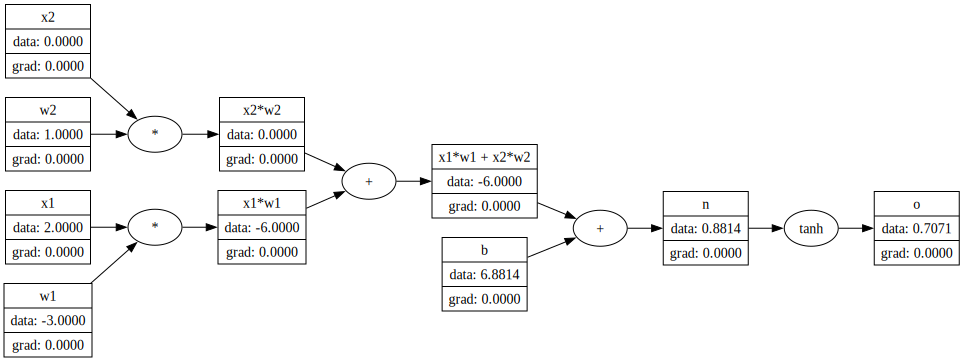

In [81]:
# 2 dimensional neuron looks like below

# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w1
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of neuron
b = Value(6.8813735870195432, label="b")

# n = x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"

# o = tanh(n)
o = n.tanh(); o.label = "o"
draw_dot(o)

In [82]:
o.grad = 1.0

In [83]:
o._backward()

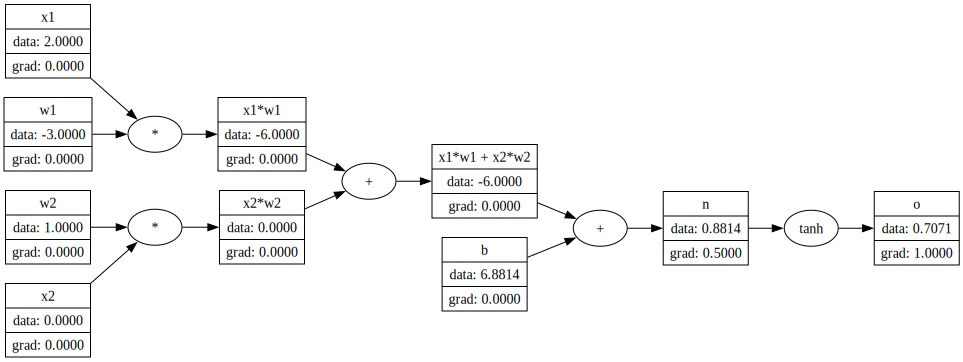

In [80]:
draw_dot(o)

In [84]:
n._backward()

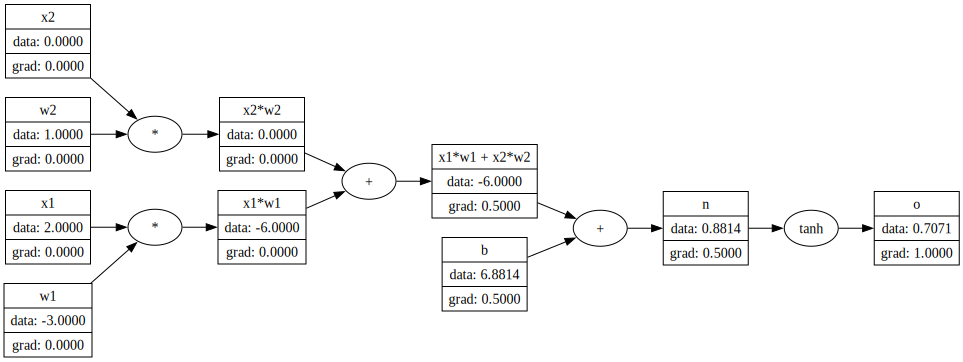

In [85]:
draw_dot(o)

In [86]:
x1w1x2w2._backward()

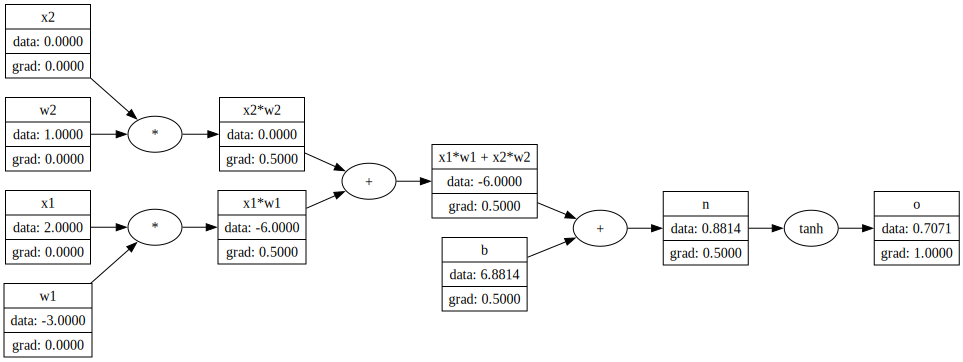

In [87]:
draw_dot(o)

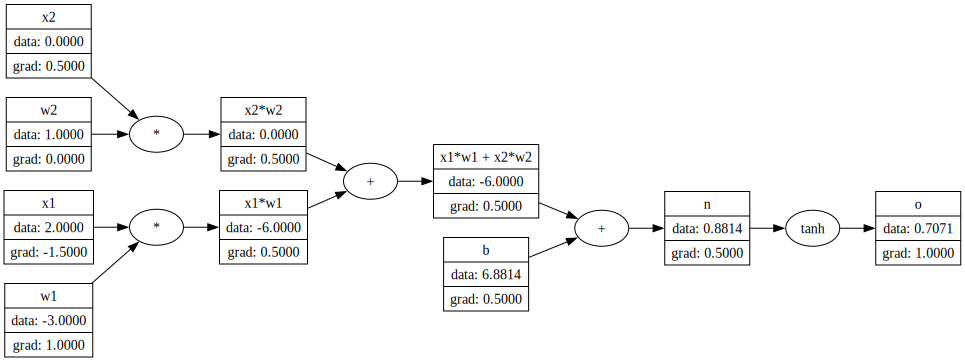

In [88]:
x1w1._backward()
x2w2._backward()
draw_dot(o)

#### automate backward pass - implement topo sort

In [89]:
topo = []
visited = set()

def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
        
build_topo(o)
topo

[Value(data=1.0, grad=0.0),
 Value(data=0.0, grad=0.4999999999999999),
 Value(data=0.0, grad=0.4999999999999999),
 Value(data=-3.0, grad=0.9999999999999998),
 Value(data=2.0, grad=-1.4999999999999996),
 Value(data=-6.0, grad=0.4999999999999999),
 Value(data=-6.0, grad=0.4999999999999999),
 Value(data=6.881373587019543, grad=0.4999999999999999),
 Value(data=0.8813735870195432, grad=0.4999999999999999),
 Value(data=0.7071067811865476, grad=1.0)]

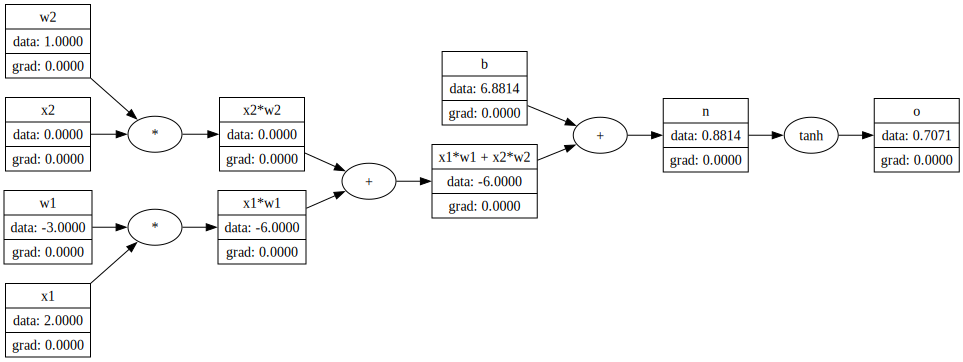

In [90]:
# 2 dimensional neuron looks like below

# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w1
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of neuron
b = Value(6.8813735870195432, label="b")

# n = x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"

# o = tanh(n)
o = n.tanh(); o.label = "o"
draw_dot(o)

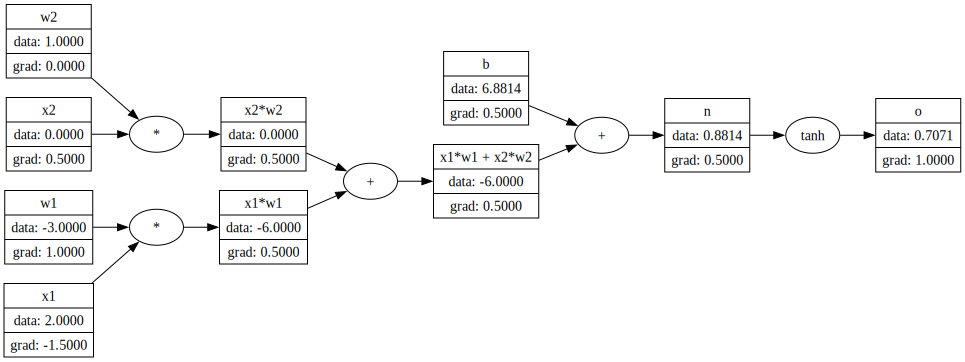

In [92]:
o.grad = 1.0

build_topo(o)

for node in reversed(topo):
    node._backward()
    
draw_dot(o)

In [93]:
# add topo graph to backward pass
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)  # previous values that contributed to this value
        self._op = _op
        self.label = label
        self._backward = lambda: None
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            data=self.data + other.data,
            _children=(self, other),
            _op="+",
            label=f"{self.label}+{other.label}"
        )
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(
            data=self.data * other.data, 
            _children=(self, other),
            _op="*",
            label=f"{self.label}+{other.label}"
        )
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
        out = Value(t, _children=(self,), _op="tanh", label=f"tanh({self.label})")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
     
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self, other): # other * self
        return self.__mul__(other)

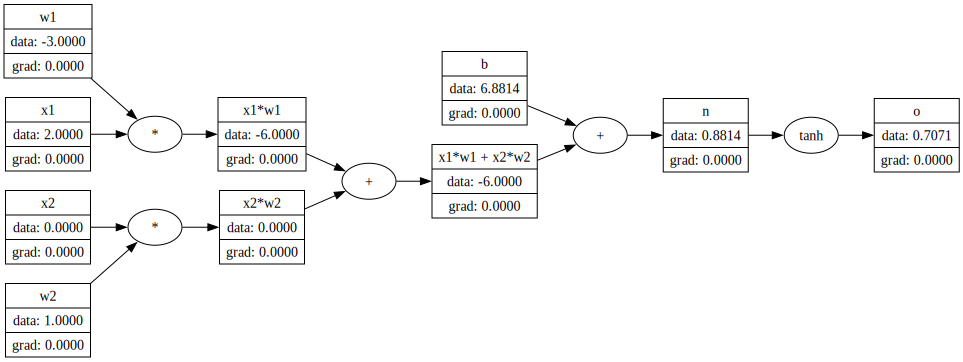

In [94]:
# 2 dimensional neuron looks like below

# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w1
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of neuron
b = Value(6.8813735870195432, label="b")

# n = x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"

# o = tanh(n)
o = n.tanh(); o.label = "o"
draw_dot(o)

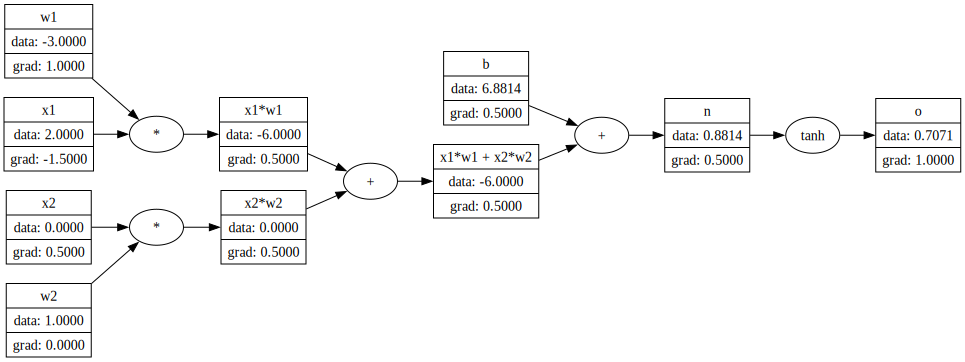

In [95]:
o.backward()
draw_dot(o)

#### add few more atomic operations to Value: break tanh

In [120]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)  # previous values that contributed to this value
        self._op = _op
        self.label = label
        self._backward = lambda: None
    
    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    
    def __add__(self, other): # self + other
        other = other if isinstance(other, Value) else Value(other, label=other)
        out = Value(
            data=self.data + other.data,
            _children=(self, other),
            _op="+",
            label=f"{self.label}+{other.label}"
        )
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __mul__(self, other): # self * other
        other = other if isinstance(other, Value) else Value(other, label=other)
        out = Value(
            data=self.data * other.data, 
            _children=(self, other),
            _op="*",
            label=f"{self.label}*{other.label}"
        )
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(
            data=self.data ** other,
            _children=(self,),
            _op="**",
            label=f"{self.label}**{other}"
        )
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1
        
    def exp(self):
        out = Value(
            data=math.exp(self.data),
            _children=(self,),
            _op="exp",
            label=f"exp({self.label})"
        )
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/ (math.exp(2*x) + 1)
        out = Value(t, _children=(self,), _op="tanh", label=f"tanh({self.label})")
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
        
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
     
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
        
    def __radd__(self, other): # other + self
        return self + other
    
    def __rmul__(self, other): # other * self
        return self * other

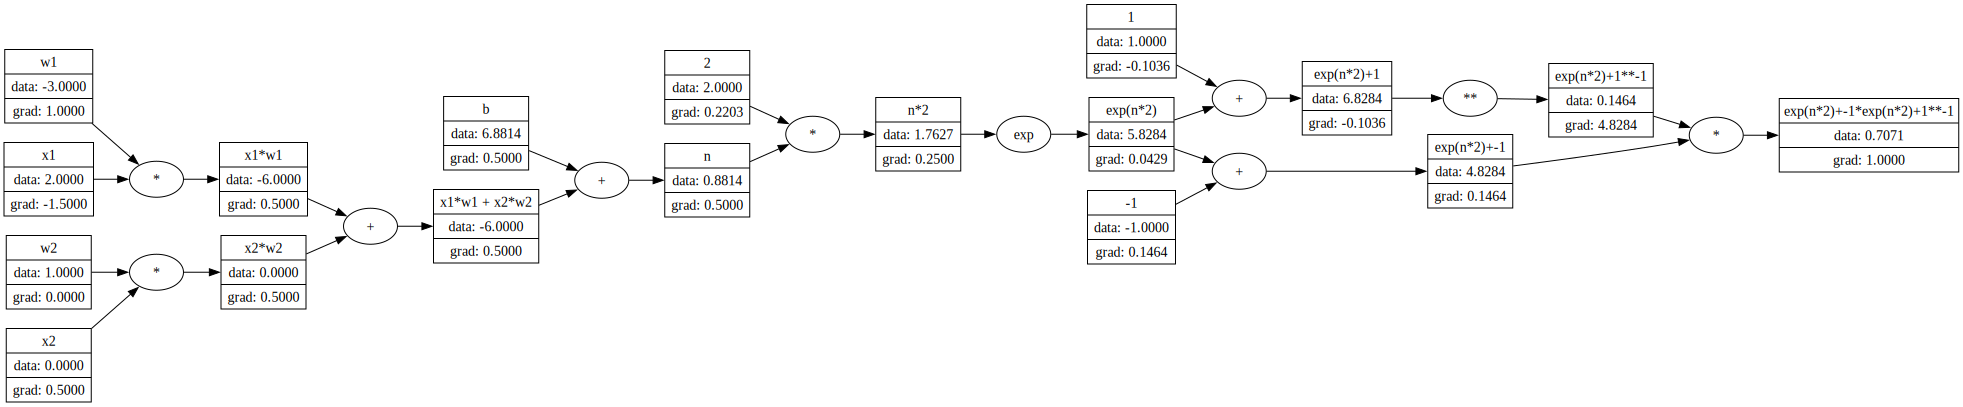

In [121]:
# 2 dimensional neuron looks like below

# inputs x1, x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights w1, w1
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias of neuron
b = Value(6.8813735870195432, label="b")

# n = x1*w1 + x2*w2 + b
x1w1 = x1 * w1; x1w1.label = "x1*w1"
x2w2 = x2 * w2; x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label = "n"

# o = tanh(n)
e = (2*n).exp(); label = "e"
o = (e-1)/(e+1); label = "o"

o.backward()
draw_dot(o)

In [ ]:
# TODO: fix the weird label situation in above's graphviz thing

#### build MLP

In [ ]:
import random

In [175]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # element-wise multiplication of weights and inputs -> take a sum -> add bias
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

# x = [2.0, 3.0]
# n = Neuron(2)
# n(x)

In [176]:
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params += neuron.parameters()
        return params

# x = [2.0, 3.0]
# l = Layer(2, 3)
# l(x)

In [271]:
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0.0

x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=-0.6171458275684183, grad=0.0)

In [178]:
# draw_dot(mlp(x))

#### train (manually)

In [288]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [289]:
len(mlp.parameters())

41

In [374]:
ypred = [mlp(x) for x in xs]

# mean squared error loss
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=2.3185271628302777, grad=0.0)

In [375]:
mlp.zero_grad()

In [376]:
loss.backward()

In [377]:
for p in mlp.parameters():
    p.data += -0.01 * p.grad

In [378]:
ypred

[Value(data=0.29103733564460477, grad=-1.4179253287107905),
 Value(data=-0.14108644397806736, grad=1.7178271120438653),
 Value(data=-0.24900552412271187, grad=1.5019889517545764),
 Value(data=0.2829407947289619, grad=-1.4341184105420761)]

In [379]:
mlp.layers[0].neurons[0].w[0]

Value(data=0.5800313112513567, grad=0.14368228246754025)

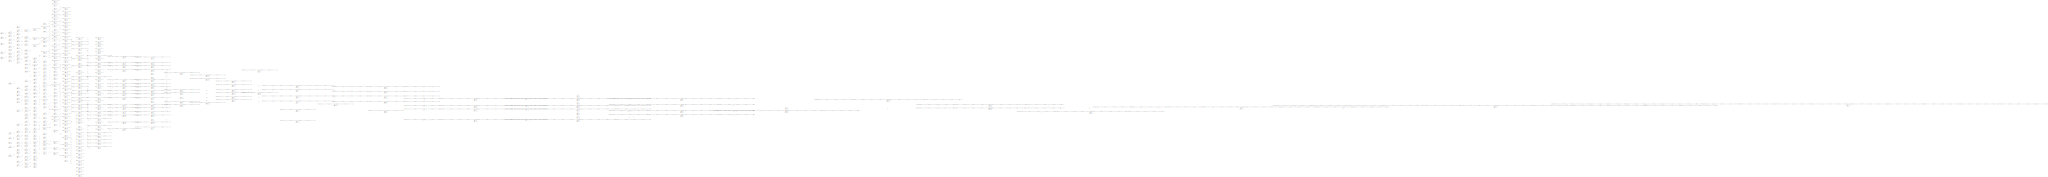

In [ ]:
# draw_dot(loss)

#### train (automate)

In [391]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0] # desired targets

mlp = MLP(3, [4, 4, 1])

In [394]:
epochs = 50
lr = 0.05
for k in range(epochs):
    # forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # flush gradients
    mlp.zero_grad()
    
    # backward pass
    loss.backward()
    
    # update
    for p in mlp.parameters():
        p.data += -lr * p.grad
    
    print(k, loss.data)

0 0.014271506552459796
1 0.013943740449617345
2 0.013630223829541538
3 0.01333005693562169
4 0.013042413781510678
5 0.012766534770687227
6 0.012501720182166798
7 0.012247324406326037
8 0.012002750832201557
9 0.011767447302144287
10 0.011540902061875314
11 0.011322640144211478
12 0.011112220133351194
13 0.010909231263901711
14 0.010713290815015928
15 0.01052404176527039
16 0.01034115067840826
17 0.010164305793912474
18 0.009993215299671452
19 0.009827605766835067
20 0.009667220729400777
21 0.009511819393182998
22 0.009361175460648494
23 0.009215076059686099
24 0.009073320765763164
25 0.0089357207081236
26 0.008802097751734766
27 0.008672283747611689
28 0.008546119844953633
29 0.008423455859238808
30 0.008304149691045553
31 0.008188066790921208
32 0.008075079666104209
33 0.00796506742533647
34 0.007857915358383667
35 0.007753514547220028
36 0.007651761506134752
37 0.007552557848284973
38 0.007455809976459356
39 0.007361428796028939
40 0.007269329448253597
41 0.0071794310622817
42 0.00709

In [395]:
ypred

[Value(data=0.9622595585010815, grad=-0.07548088299783706),
 Value(data=-0.955333962858552, grad=0.08933207428289602),
 Value(data=-0.9589668097698314, grad=0.08206638046033721),
 Value(data=0.9622137264022494, grad=-0.0755725471955011)]